In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prasandhareshwar","key":"fd3adb3ee1804cdfcee9b32084b19da9"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download --force -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:16<00:00, 79.3MB/s]
100% 1.33G/1.33G [00:16<00:00, 84.1MB/s]


In [4]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [5]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

In [6]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [7]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 202599 images belonging to 1 classes.


In [8]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)


In [9]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)       

In [10]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [11]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2])
decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              823296    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)       

In [12]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)       

In [13]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)

In [14]:
simple_autoencoder.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                                 callbacks=[checkpoint_ae])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
396/395 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00001: saving model to ./weights/AE/weights.h5
396/395 [==============================] - 242s 611ms/step - loss: 0.0282
Epoch 2/10
396/395 [==============================] - ETA: 0s - loss: 0.0109
Epoch 00002: saving model to ./weights/AE/weights.h5
396/395 [==============================] - 241s 608ms/step - loss: 0.0109
Epoch 3/10
396/395 [==============================] - ETA: 0s - loss: 0.0092
Epoch 00003: saving model to ./weights/AE/weights.h5
396/395 [==============================] - 240s 607ms/step - loss: 0.0092
Epoch 4/10
396/395 [==============================] - ETA: 0s - loss: 0.0084
Epoch 00004: saving model to ./weights/AE/weights.h5
396/395 [==============================] - 239s 603ms/step - loss: 0.0084
Epoch 5/10
396/395 [==============================] - ETA: 0s - loss: 0.0080
Epoch 00005: saving model to ./

In [15]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [16]:
example_images.shape


(10, 128, 128, 3)

In [17]:
import matplotlib.pyplot as plt


In [18]:
def plot_compare(images=None, add_noise=False):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

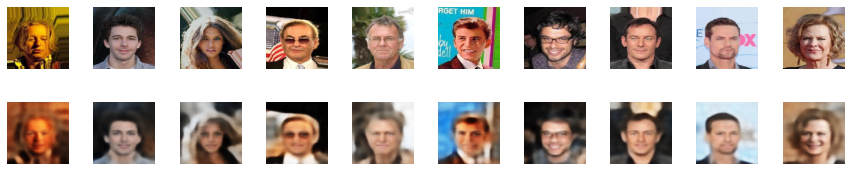

In [19]:
plot_compare(example_images)


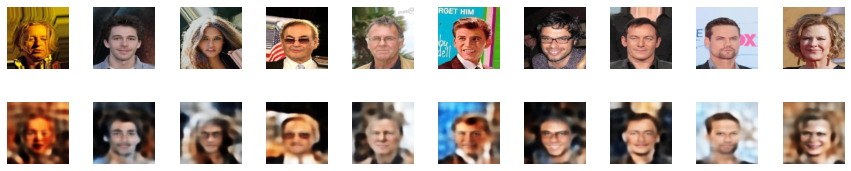

In [20]:
plot_compare(images = example_images, add_noise = True)


In [21]:
def generate_images_from_noise(n_to_show = 10): 
  reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

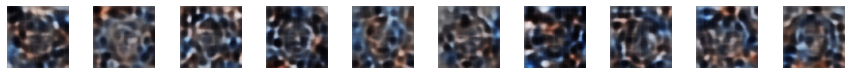

In [22]:
generate_images_from_noise()


In [23]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [24]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [25]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              823296    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)       

In [26]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [27]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [28]:
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [29]:
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [32]:
vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                        callbacks=[checkpoint_vae])

Epoch 1/200


_SymbolicException: ignored

In [ ]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [ ]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

In [ ]:
plot_compare_vae(images = example_images)


In [ ]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

In [ ]:
vae_generate_images(n_to_show=10)